In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/final_grape_data.zip

Archive:  /content/drive/MyDrive/final_grape_data.zip
   creating: final_grape_data/image/
  inflating: final_grape_data/image/1 (1).png  
  inflating: final_grape_data/image/1 (10).png  
  inflating: final_grape_data/image/1 (100).png  
  inflating: final_grape_data/image/1 (101).png  
  inflating: final_grape_data/image/1 (102).png  
  inflating: final_grape_data/image/1 (103).png  
  inflating: final_grape_data/image/1 (104).png  
  inflating: final_grape_data/image/1 (105).png  
  inflating: final_grape_data/image/1 (106).png  
  inflating: final_grape_data/image/1 (107).png  
  inflating: final_grape_data/image/1 (108).png  
  inflating: final_grape_data/image/1 (109).png  
  inflating: final_grape_data/image/1 (11).png  
  inflating: final_grape_data/image/1 (110).png  
  inflating: final_grape_data/image/1 (111).png  
  inflating: final_grape_data/image/1 (112).png  
  inflating: final_grape_data/image/1 (113).png  
  inflating: final_grape_data/image/1 (114).png  
  inflating: 

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import os

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [ ]:
import keras.models as models
from keras.layers import Layer, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
import cv2
import numpy as np

np.random.seed(7)

# Function to create encoding layers
def create_encoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        ZeroPadding2D(padding=(pad, pad)),
        Conv2D(filter_size, (kernel, kernel), padding='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad, pad)),
        Conv2D(128, (kernel, kernel), padding='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad, pad)),
        Conv2D(256, (kernel, kernel), padding='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad, pad)),
        Conv2D(512, (kernel, kernel), padding='valid'),
        BatchNormalization(),
        Activation('relu'),
    ]

# Function to create decoding layers
def create_decoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        ZeroPadding2D(padding=(pad, pad)),
        Conv2D(512, (kernel, kernel), padding='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size, pool_size)),
        ZeroPadding2D(padding=(pad, pad)),
        Conv2D(256, (kernel, kernel), padding='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size, pool_size)),
        ZeroPadding2D(padding=(pad, pad)),
        Conv2D(128, (kernel, kernel), padding='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size, pool_size)),
        ZeroPadding2D(padding=(pad, pad)),
        Conv2D(filter_size, (kernel, kernel), padding='valid'),
        BatchNormalization(),
    ]

segnet_basic = models.Sequential()
segnet_basic.add(Layer(input_shape=(128, 128, 3)))

# Add encoding layers
segnet_basic.encoding_layers = create_encoding_layers()
for l in segnet_basic.encoding_layers:
    segnet_basic.add(l)

# Add decoding layers
segnet_basic.decoding_layers = create_decoding_layers()
for l in segnet_basic.decoding_layers:
    segnet_basic.add(l)

segnet_basic.add(Conv2D(1, (1, 1), padding='valid', activation='sigmoid'))

In [ ]:
def read_and_preprocess_images(folder_path, target_size=(128, 128), grayscale=False):
    images = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            if grayscale:
                image = cv2.imread(image_path, 0)
                image = np.expand_dims(image, axis=-1)
            else:
                image = cv2.imread(image_path)
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, target_size)
            images.append(image)
    return np.array(images)

In [ ]:
images = read_and_preprocess_images('/content/final_grape_data/image', target_size=(128, 128))
masks = read_and_preprocess_images('/content/final_grape_data/mask', target_size=(128, 128), grayscale=True)

In [ ]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_train = np.array(images_train)
masks_train = np.array(masks_train)
images_test = np.array(images_test)
masks_test = np.array(masks_test)

In [ ]:
segnet_basic.compile(loss="binary_crossentropy", optimizer='adadelta', metrics=["accuracy"])

In [ ]:
segnet_basic.fit(images_train, masks_train, validation_data=(images_test, masks_test), batch_size=8, epochs=55, verbose=1)

Epoch 1/55
83/83 [==============================] - 16s 77ms/step - loss: 0.5915 - accuracy: 0.7340 - val_loss: 0.4930 - val_accuracy: 0.8463
Epoch 2/55
83/83 [==============================] - 6s 75ms/step - loss: 0.5276 - accuracy: 0.7859 - val_loss: 0.4647 - val_accuracy: 0.8536
Epoch 3/55
83/83 [==============================] - 6s 71ms/step - loss: 0.4859 - accuracy: 0.8130 - val_loss: 0.4353 - val_accuracy: 0.8944
Epoch 4/55
83/83 [==============================] - 6s 75ms/step - loss: 0.4592 - accuracy: 0.8316 - val_loss: 0.4270 - val_accuracy: 0.8898
Epoch 5/55
83/83 [==============================] - 6s 73ms/step - loss: 0.4293 - accuracy: 0.8493 - val_loss: 0.4651 - val_accuracy: 0.8289
Epoch 6/55
83/83 [==============================] - 6s 75ms/step - loss: 0.4059 - accuracy: 0.8611 - val_loss: 0.4905 - val_accuracy: 0.8142
Epoch 7/55
83/83 [==============================] - 6s 77ms/step - loss: 0.3877 - accuracy: 0.8724 - val_loss: 0.4430 - val_accuracy: 0.8494
Epoch 8/55
8

In [ ]:
results = segnet_basic.predict(images_test)
pred_mask = np.squeeze(np.where(results > 0.5, 1, 0), axis=-1)

6/6 [==============================] - 1s 74ms/step


In [ ]:
loss, acc = segnet_basic.evaluate(images_test, masks_test)
loss, acc

6/6 [==============================] - 0s 65ms/step - loss: 0.1570 - accuracy: 0.9519


(0.1570349484682083, 0.9518726468086243)

In [ ]:
segnet_basic.save('segnet1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


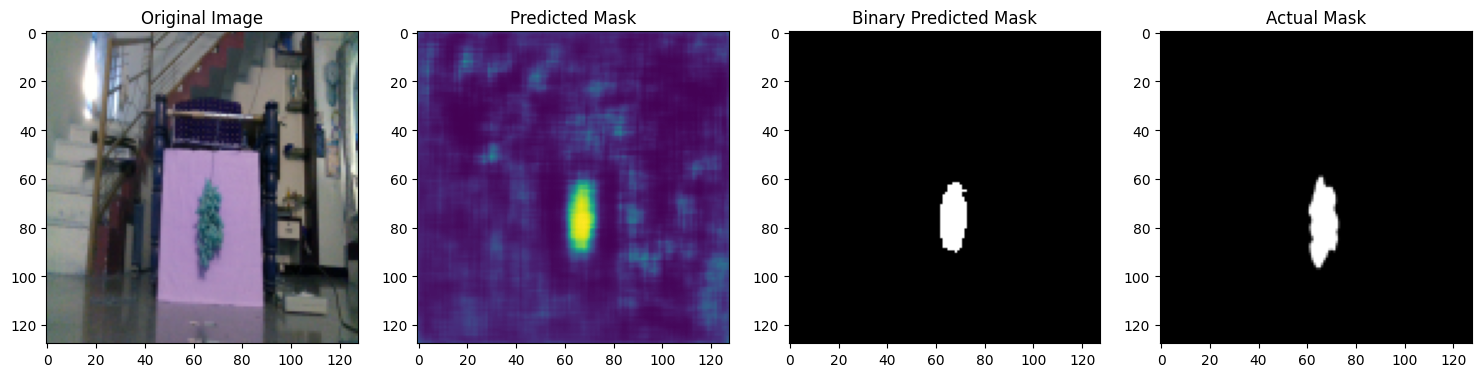

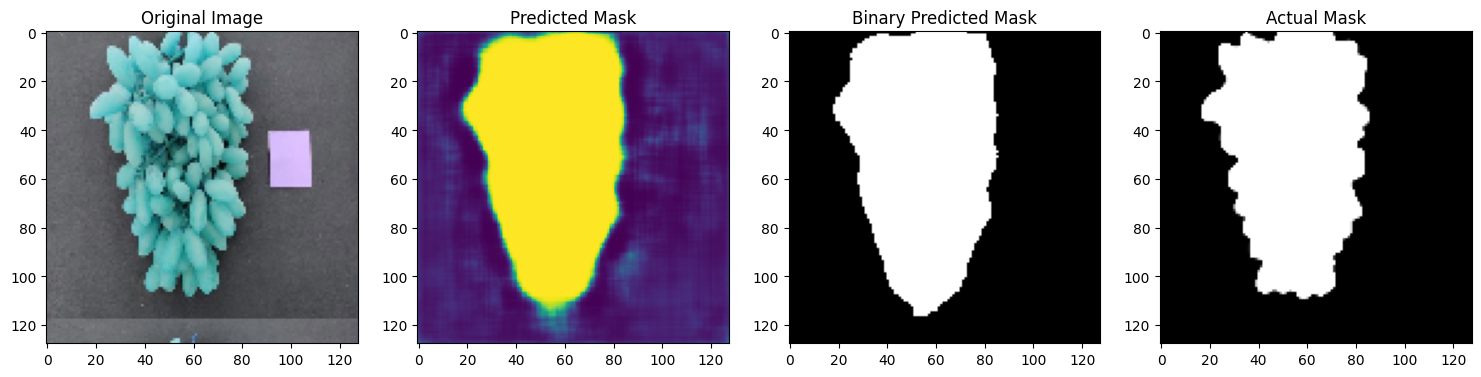

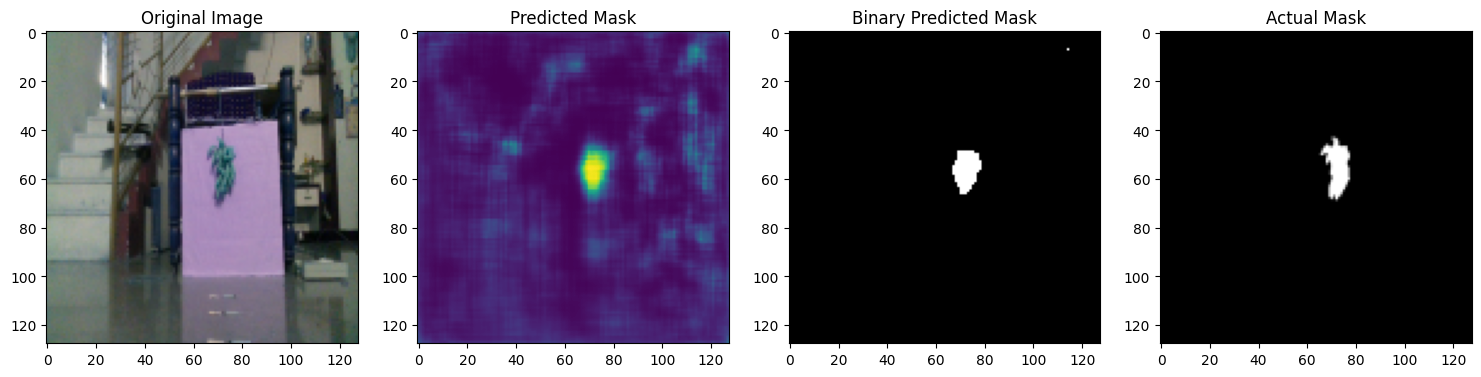

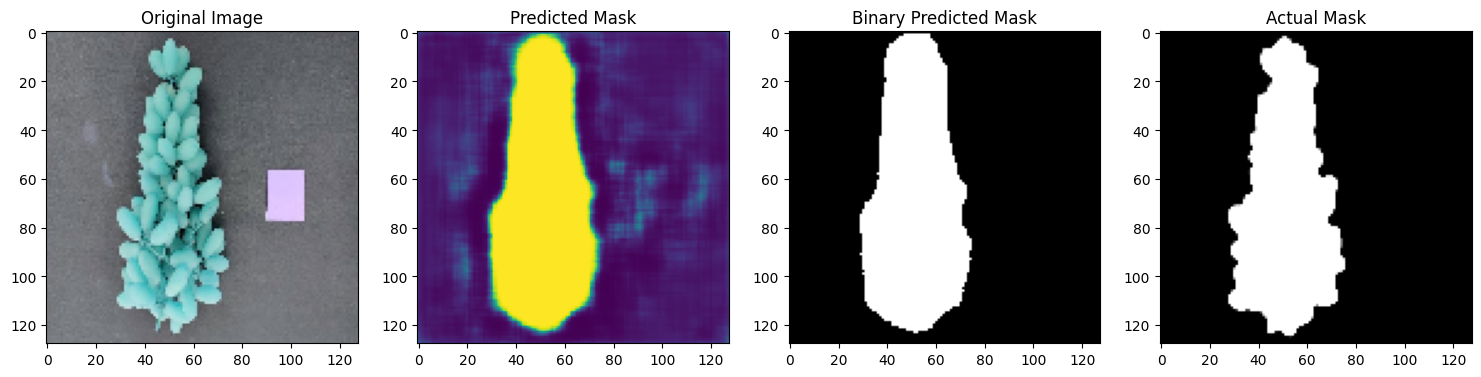

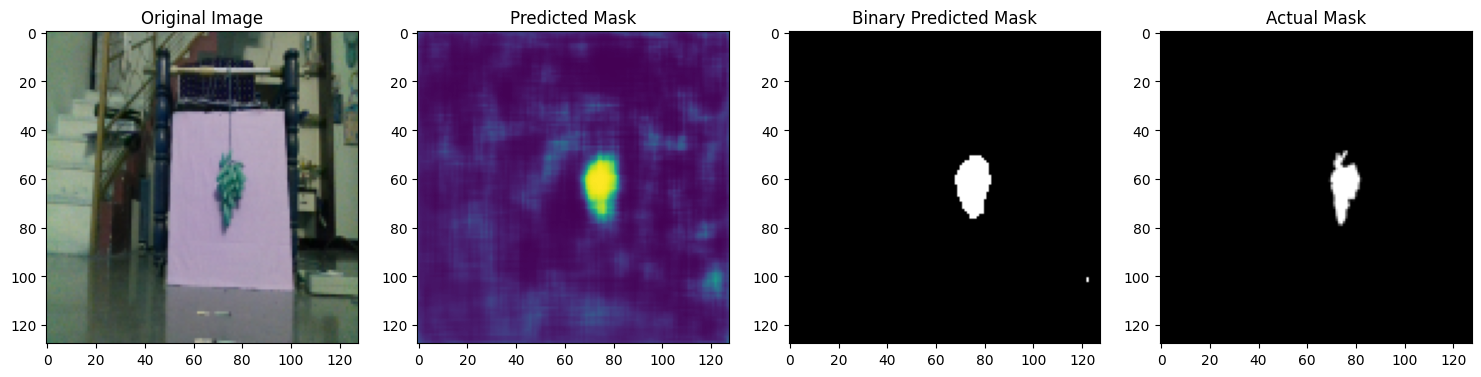

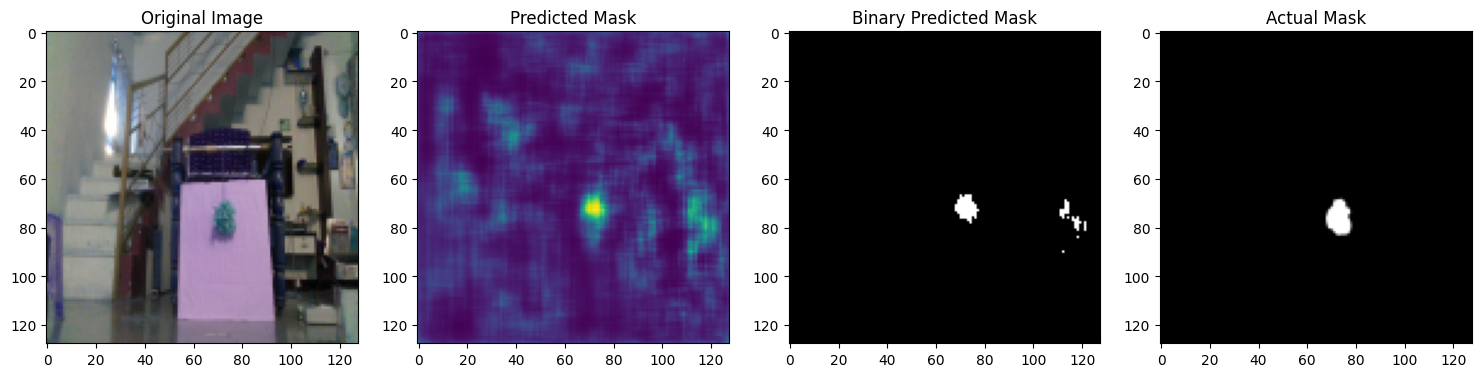

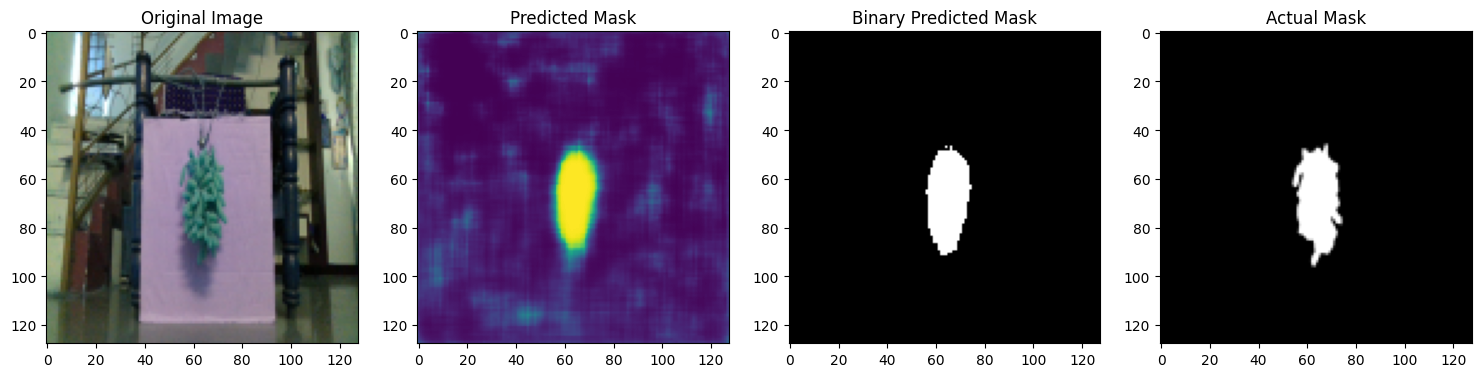

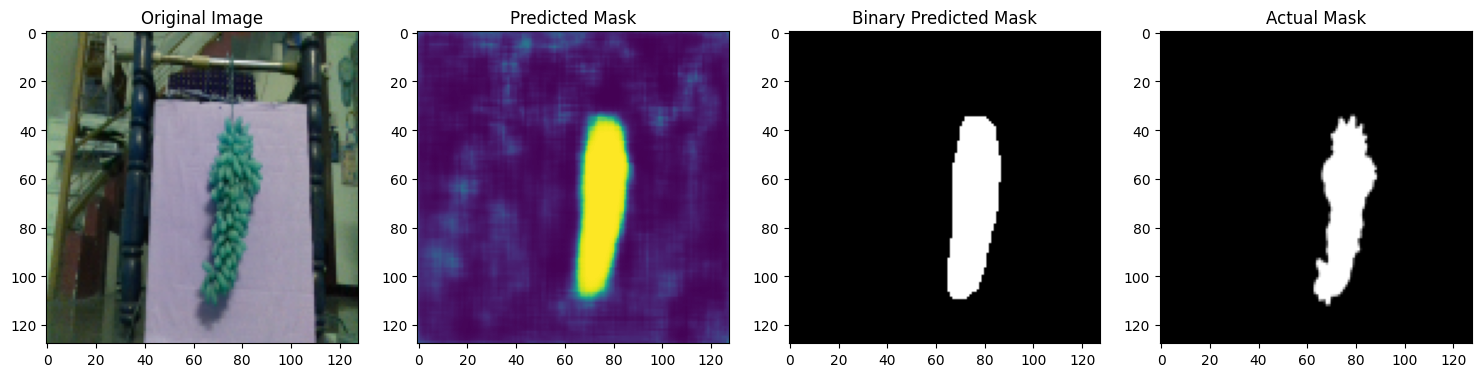

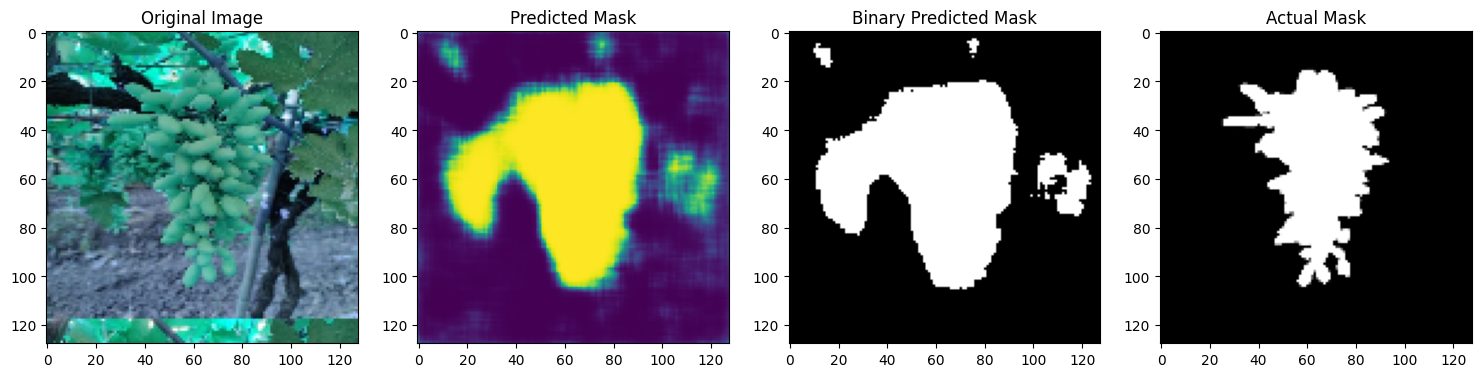

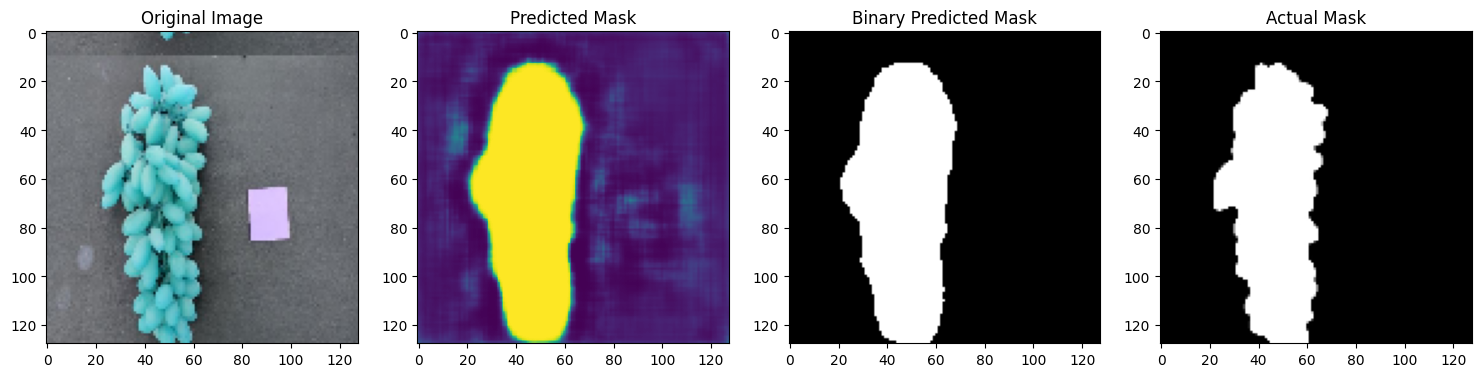

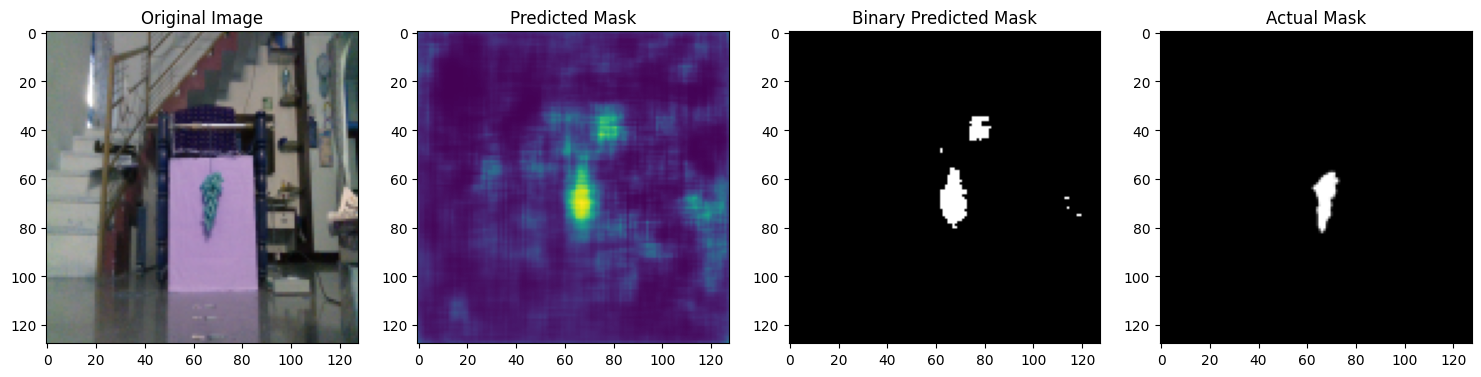

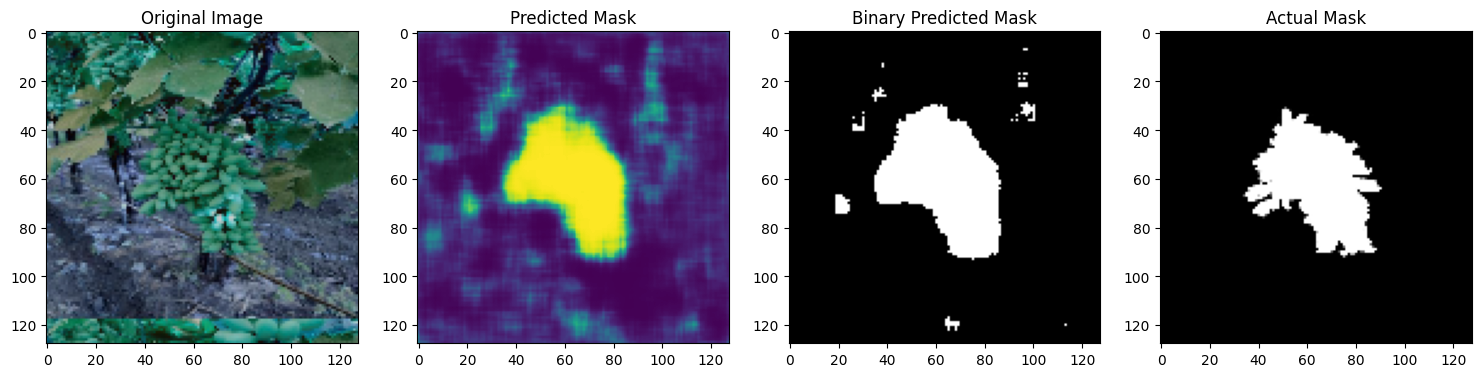

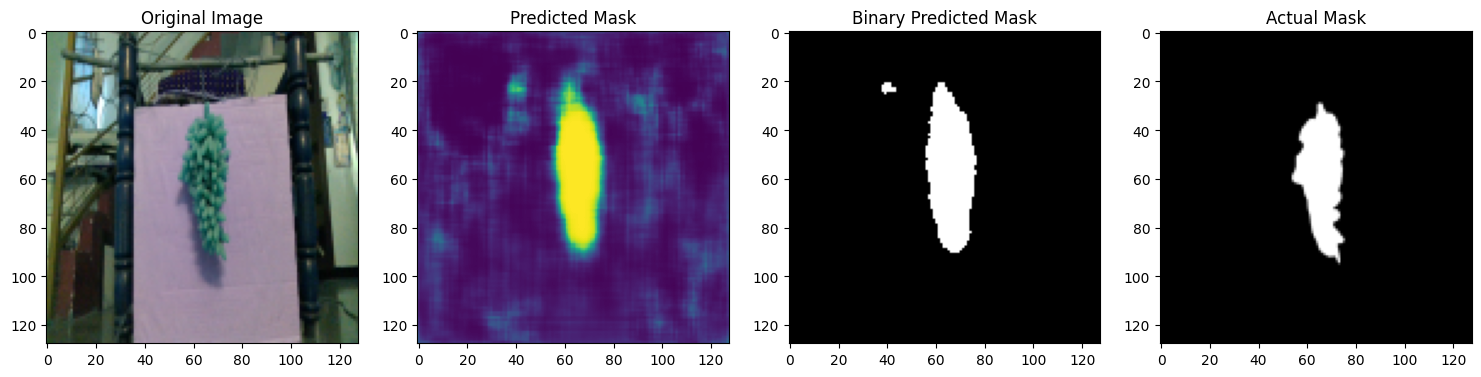

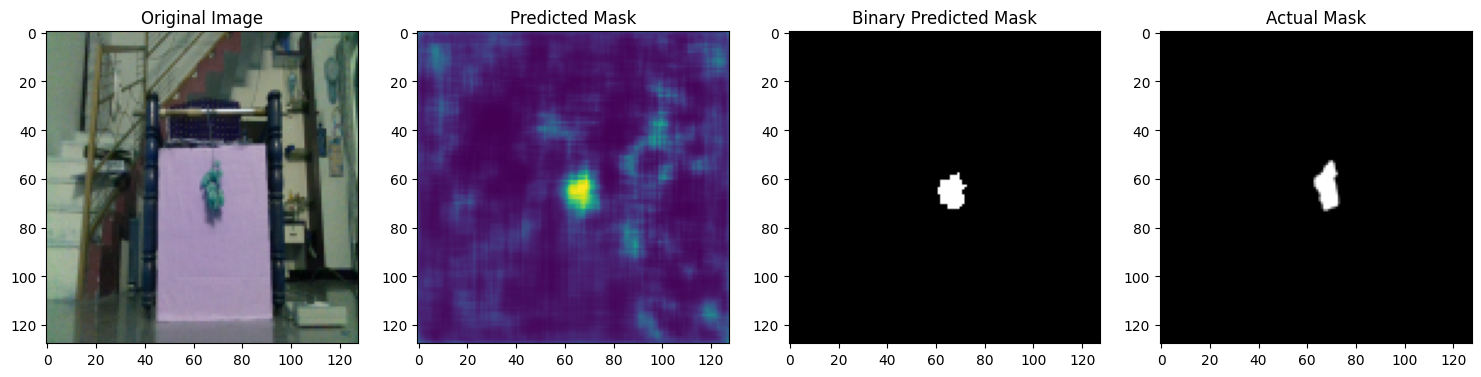

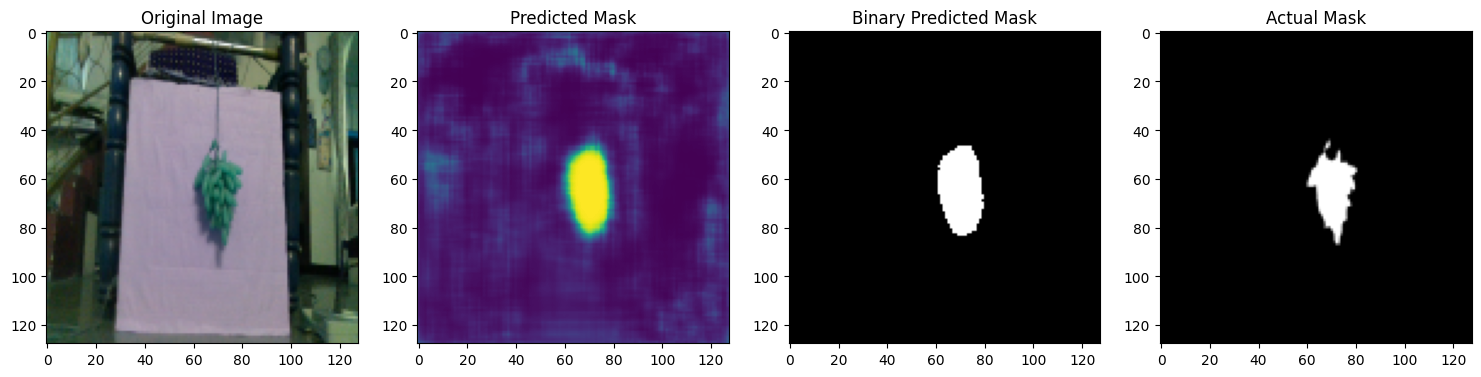

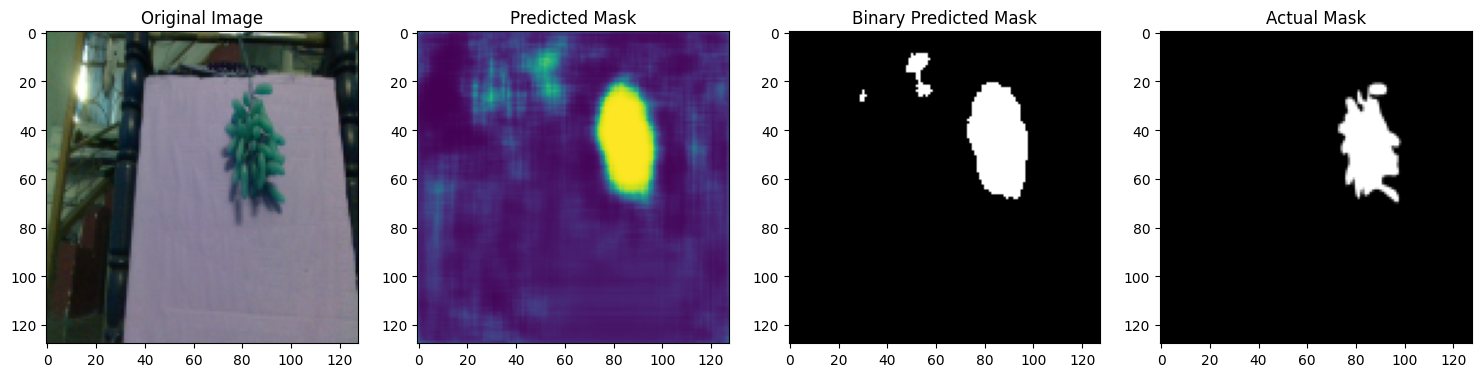

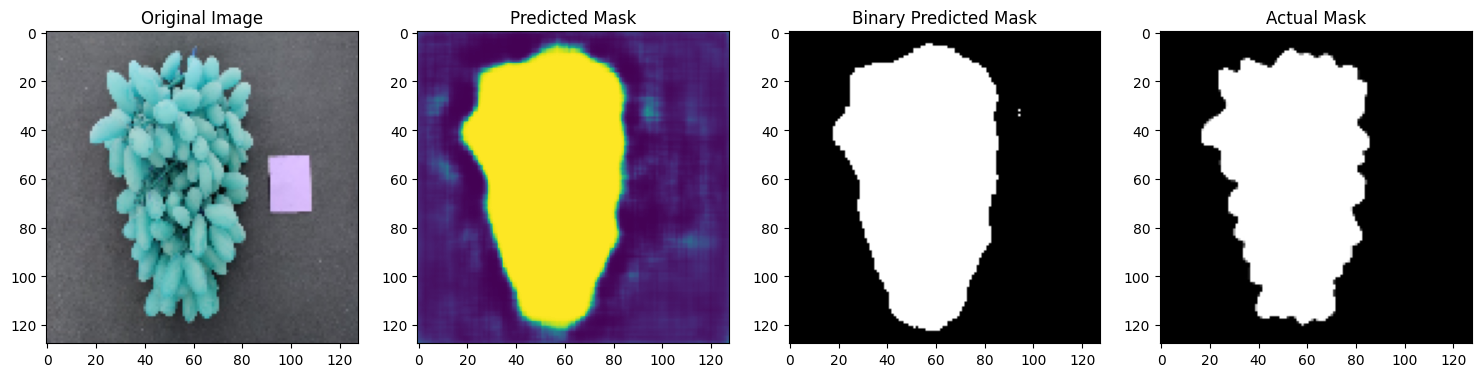

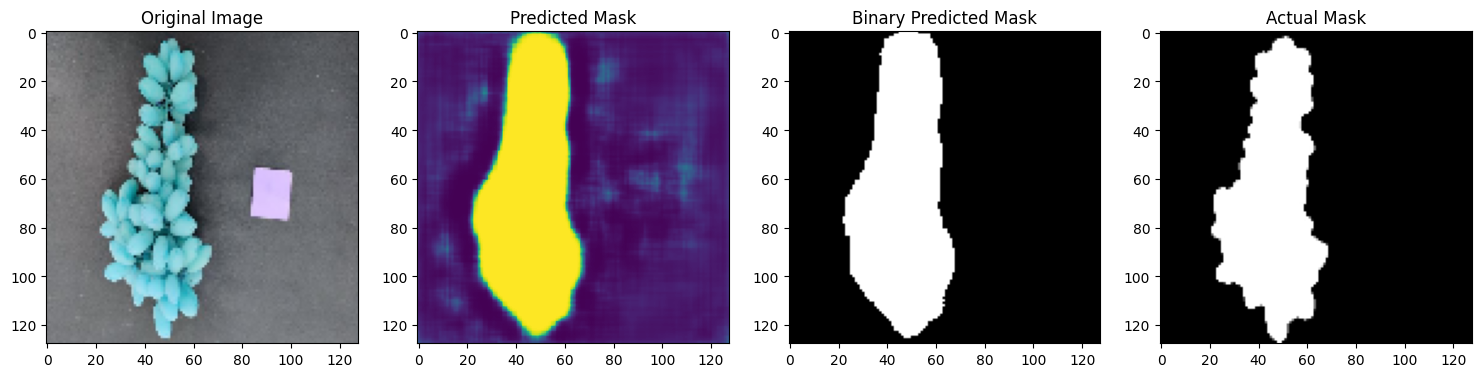

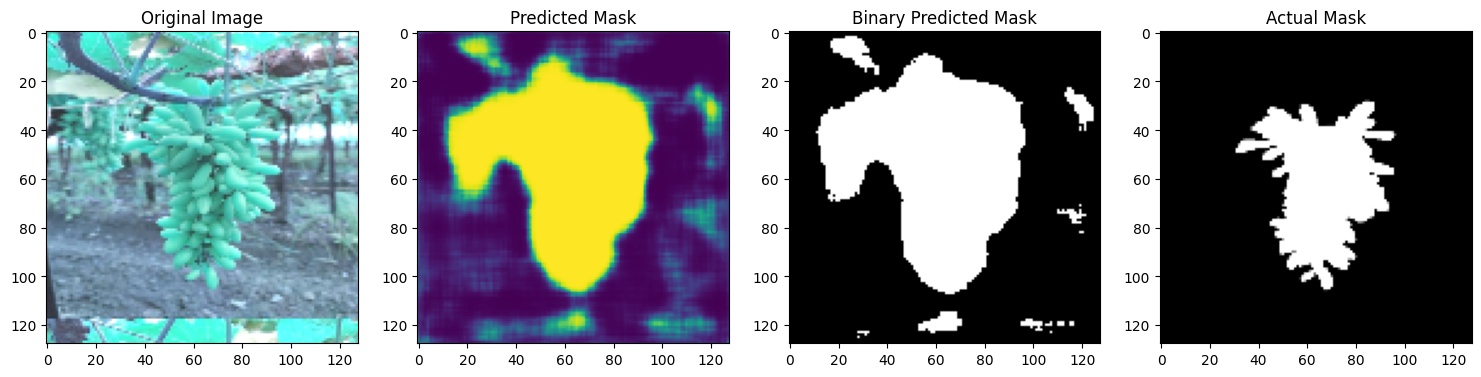

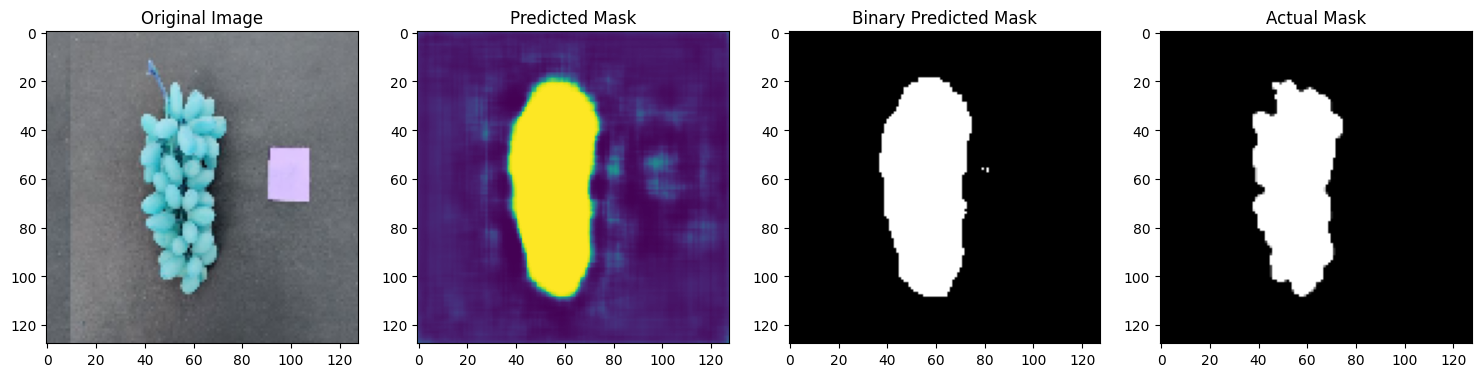

In [ ]:
for i in range(20):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(images_test[i])
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(results[i])
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask[i], cmap='gray')
    plt.title('Binary Predicted Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(masks_test[i], cmap='gray')
    plt.title('Actual Mask')
    plt.tight_layout()
    plt.show()

In [ ]:
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def compute_dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_coefficient = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_coefficient


iou = compute_iou(pred_mask, masks_test)
dice_coefficient = compute_dice_coefficient(pred_mask, masks_test)

print("IoU:", iou)
print("Dice Coefficient:", dice_coefficient)

IoU: 0.8187966749799943
Dice Coefficient: 0.8873704351859112


In [ ]:
def compute_dice_loss(y_true, y_pred):
    dice_loss = 1 - compute_dice_coefficient(y_true, y_pred)
    return dice_loss

def compute_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = 1e-7
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    focal_loss = - (alpha * y_true * ((1 - y_pred) ** gamma) * np.log(y_pred) +
                    (1 - alpha) * (1 - y_true) * (y_pred ** gamma) * np.log(1 - y_pred))
    return focal_loss.mean()

dice_loss = compute_dice_loss(pred_mask, masks_test)
focal_loss = compute_focal_loss(pred_mask, masks_test)

print("Dice Loss:", dice_loss)
print("Focal Loss:", focal_loss)

Dice Loss: 0.11262956481408881
Focal Loss: 0.11915242332802471
